# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.timeseries_generation import holidays_timeseries
import datetime
from evaluate_forecasts import darts_block_n_step_ahead_forecast
import pickle
from evaluate_forecasts import backtester

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


[2021-11-04 02:38:44,376] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


## Recurrent Models

Darts includes two recurrent forecasting model classes: `RNNModel` and `BlockRNNModel`. 

`RNNModel` is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:
- the previous target value, which will be set to the last known target value for the first prediction,
  and for all other predictions it will be set to the previous prediction
- the previous hidden state
- the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon `n` thus is created in `n` iterations of `RNNModel` predictions and requires `n` future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

`BlockRNNModel` has a recurrent encoder stage, which encodes its input, and a fully-connected neural network decoder stage, which produces a prediction of length `output_chunk_length` based on the last hidden state of the encoder stage. Consequently, this model produces 'blocks' of forecasts and is restricted to looking at covariates with the same time index as the input target series.

## RDN

In [3]:
data_root = os.path.join('..', '..', 'RDN', 'Load Data (2018-2019)', 'artifacts')
# train
cut_date_val = '20190901'
cut_date_test = '20191201'


### Preprocessing

In [4]:
# load dataset
series = TimeSeries.from_series(pd.read_csv(os.path.join(data_root, 'load_60min.csv'), index_col=0, parse_dates=True), freq='H')

# Train / Test split
train, val = series.split_before(pd.Timestamp(cut_date_val))
val, test = val.split_before(pd.Timestamp(cut_date_test))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer_ts = Scaler()

train_transformed = transformer_ts.fit_transform(train)
val_transformed = transformer_ts.transform(val)
test_transformed = transformer_ts.transform(test)
series_transformed = transformer_ts.transform(series)

# create month and year covariate series
year_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='year')
month_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='month', cyclic=True)
day_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='day', cyclic=True)
hour_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='hour', cyclic=True)
dayofweek_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='dayofweek')
dayofyear_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='dayofyear')
weekofyear_60 = datetime_attribute_timeseries(time_index=series_transformed, attribute='weekofyear')
holidays_60 = holidays_timeseries(time_index=series_transformed.time_index, country_code='PT')

covariates = year_60.stack(month_60) \
                    .stack(day_60) \
                    .stack(hour_60) \
                    .stack(dayofweek_60) \
                    .stack(dayofyear_60) \
                    .stack(weekofyear_60) \
                    .stack(holidays_60)

# scale them between 0 and 1:
transformer_cov = Scaler()
covariates = transformer_cov.fit_transform(covariates)

# split in train/validation sets:
cov_train, cov_val = covariates.split_before(pd.Timestamp(cut_date_val))
cov_val, cov_test = cov_val.split_before(pd.Timestamp(cut_date_test))


### Training
Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.
What is training length compared to input chunk length?


**training_length** – The length of both input (target and covariates) and output (target) time series used during training. Generally speaking, training_length should have a higher value than input_chunk_length because otherwise during training the RNN is never run for as many iterations as it will during prediction. 
Training dataset:
| input      | output |
| ----------- | ----------- |
| target_ts (t ... t + training_size), covariates(t ... t + training_size)]      | [target_ts [t+1 ... t + 1 + training_size]       |

Each row of this table starts with predicting the first element of the output target_ts [t+1] and then the rest are predicted in a recurrent manner. Therefore, the network is optimised to function well in this manner.

In [19]:
n_epochs = 150
input_chunk_length = 5*24
training_length = 5*24
random_state = 42
nr_epochs_val_period = 20
n_rnn_layers = 1
rnn_type = 'LSTM'
hidden_dim = 128

model_name = f'{rnn_type}_60min_start_20180101_val_{cut_date_val}_test_{cut_date_test}input_chunk_{str(int(input_chunk_length))}_training_length_{str(int(training_length))}_hidden_dim_{hidden_dim}_n_rnns_{n_rnn_layers}_epochs_{str(n_epochs)}_random_state_{random_state}_plus_time'
models_dir = os.path.join('.', '.darts', 'checkpoints')


In [20]:
my_model = RNNModel(
    model=rnn_type,
    hidden_dim=hidden_dim,
    dropout=0,
    n_rnn_layers=n_rnn_layers,
    batch_size=32,
    n_epochs=n_epochs,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name=model_name,
    log_tensorboard=True,
    random_state=random_state,
    training_length=training_length,
    input_chunk_length=input_chunk_length,
    torch_device_str='cuda',
    nr_epochs_val_period=nr_epochs_val_period
)


Also save scalers to enable reverse scaling during inference for stakeholders

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [21]:
my_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
pickle.dump(transformer_ts, open(os.path.join(models_dir, model_name, "scaler.pkl"), "wb"))

### Evaluation on test set

In [ ]:
# evaluation
backtest_start_date = pd.Timestamp(cut_date_test)
backtest_end_date = series.time_index[-1].date()

#### Load best model

In [23]:
# Load best model
best_model = RNNModel.load_from_checkpoint(model_name=model_name, best=True)
# Set path to save evaluation results
path_to_save_eval = os.path.join(models_dir, model_name)


loading model_best_40.pth.tar


#### Day ahead forecasts

  0%|          | 0/30 [00:00<?, ?it/s]

MAPE: 4.47%


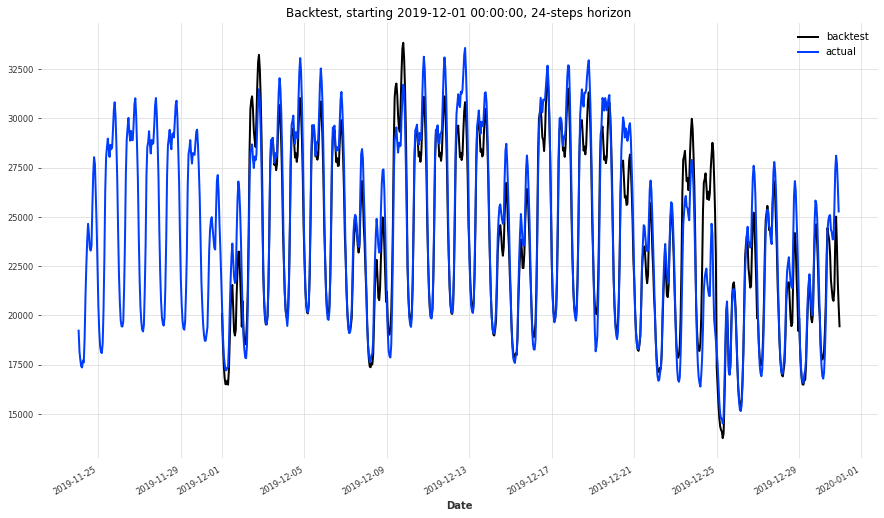

In [24]:
# mape_error, pred = darts_block_n_step_ahead_forecast(best_model,
#                                                      train_transformed.append(
#                                                          val_transformed),
#                                                      test_transformed,
#                                                      block_n_steps=24,
#                                                      n_blocks=1,
#                                                      path_to_save_eval=path_to_save_eval)
forecast_horizon = 24
stride = forecast_horizon
path_to_save_backtest = path_to_save_eval
transformer_ts = pickle.load(open(os.path.join(path_to_save_eval, 'scaler.pkl'), "rb"))

mape_error, backtest = backtester(model=best_model,
                                  series_transformed=series_transformed.drop_after(
                                                     backtest_end_date),
                                  backtest_start_date=backtest_start_date,
                                  forecast_horizon=forecast_horizon,
                                  stride=stride,
                                  transformer_ts=transformer_ts,
                                  retrain=False,
                                  future_covariates=covariates,
                                  past_covariates=None,
                                  path_to_save_backtest=path_to_save_backtest)


#### 1 hour ahead forecasts

  0%|          | 0/720 [00:00<?, ?it/s]

MAPE: 1.00%


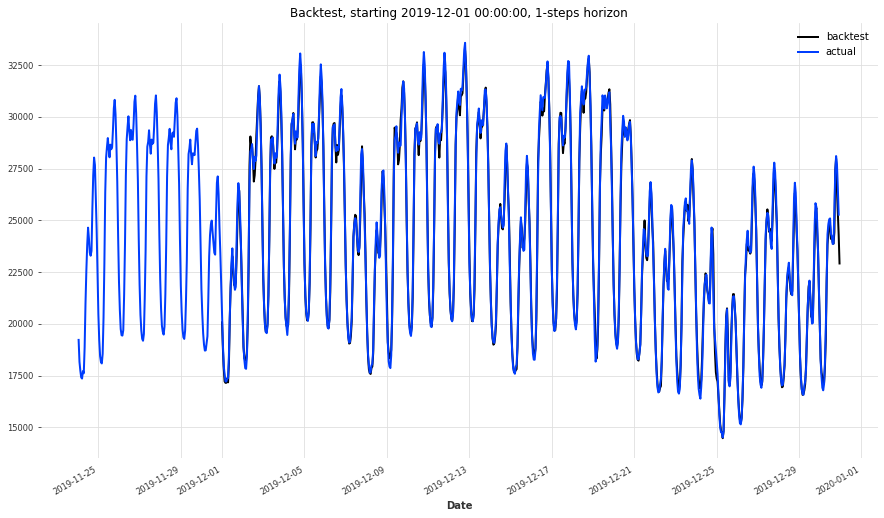

In [25]:
forecast_horizon = 1
stride = forecast_horizon
path_to_save_backtest = path_to_save_eval
transformer_ts = pickle.load(
    open(os.path.join(path_to_save_eval, 'scaler.pkl'), "rb"))

mape_error, backtest = backtester(model=best_model,
                                  series_transformed=series_transformed.drop_after(
                                      pd.Timestamp(backtest_end_date)),
                                  backtest_start_date=backtest_start_date,
                                  forecast_horizon=forecast_horizon,
                                  stride=stride,
                                  transformer_ts=transformer_ts,
                                  retrain=False,
                                  future_covariates=covariates,
                                  past_covariates=None,
                                  path_to_save_backtest=path_to_save_backtest)


#### 3 hour ahead forecast

  0%|          | 0/240 [00:00<?, ?it/s]

MAPE: 2.40%


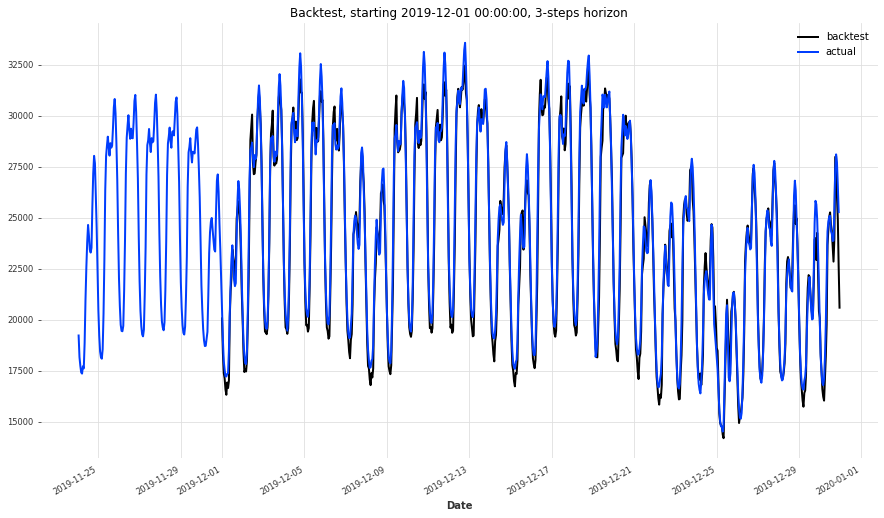

In [18]:
forecast_horizon = 3
stride = forecast_horizon
path_to_save_backtest = path_to_save_eval
transformer_ts = pickle.load(
    open(os.path.join(path_to_save_eval, 'scaler.pkl'), "rb"))

mape_error, backtest = backtester(model=best_model,
                                  series_transformed=series_transformed.drop_after(
                                      pd.Timestamp(backtest_end_date)),
                                  backtest_start_date=backtest_start_date,
                                  forecast_horizon=forecast_horizon,
                                  stride=stride,
                                  transformer_ts=transformer_ts,
                                  retrain=False,
                                  future_covariates=covariates,
                                  past_covariates=None,
                                  path_to_save_backtest=path_to_save_backtest)


### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 3 hours. For future timestamps backtesting works different than the advanced forecast in the sense that it does not have available the history of the timeseries.

In [15]:
path_to_save_eval = os.path.join(models_dir, model_name)

  0%|          | 0/96 [00:00<?, ?it/s]

<TimeSeries (DataArray) (time: 3, component: 1, sample: 1)>
array([[[21554.90317202]],

       [[19559.70306088]],

       [[18273.71407468]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-12-20 ... 2019-12-20T02:00:00
  * component  (component) object 'Load'
Dimensions without coordinates: sample
MAPE: 3.83%


(3.82703696448098,
 <TimeSeries (DataArray) (time: 3, component: 1, sample: 1)>
 array([[[21554.90317202]],
 
        [[19559.70306088]],
 
        [[18273.71407468]]])
 Coordinates:
   * time       (time) datetime64[ns] 2019-12-20 ... 2019-12-20T02:00:00
   * component  (component) object 'Load'
 Dimensions without coordinates: sample)

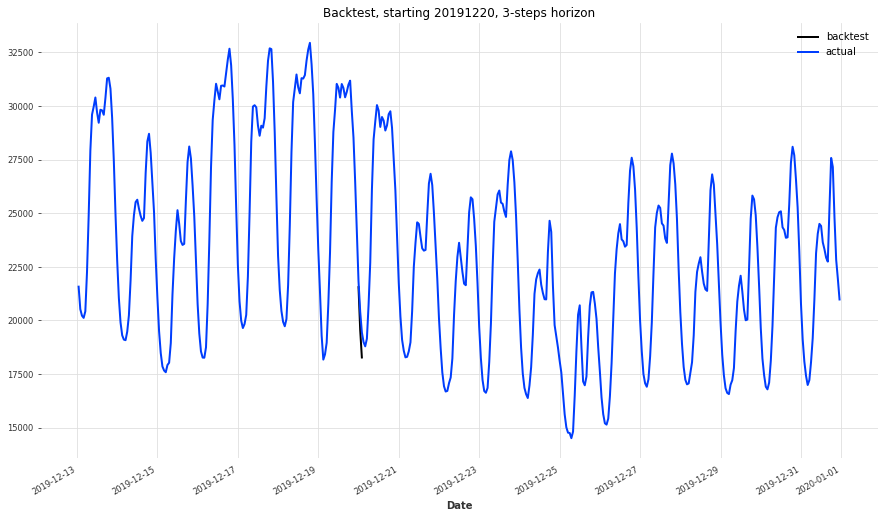

In [22]:
backtest_start_date = '20191220'
forecast_horizon = 3
path_to_save_backtest = path_to_save_eval
transformer_ts = pickle.load(open(os.path.join(path_to_save_eval, 'scaler.pkl'), "rb"))

backtester(model=best_model,
           series_transformed=series_transformed,
           backtest_start_date=backtest_start_date,
           forecast_horizon=forecast_horizon,
           transformer_ts=transformer_ts,
           retrain=False,
           future_covariates=covariates,
           past_covariates=None,
           path_to_save_backtest=path_to_save_backtest)


MAPE: 0.99%


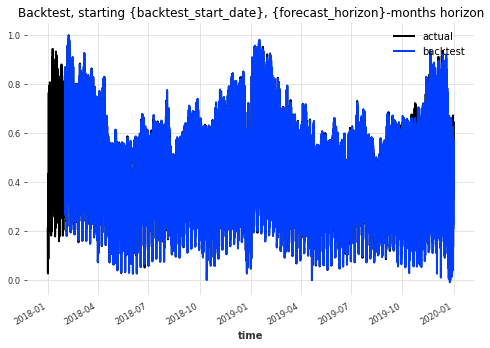

In [26]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting {backtest_start_date}, {forecast_horizon}-months horizon')
print('MAPE: {:.2f}%'.format(mape(transformer_ts.inverse_transform(series_transformed), 
                                  transformer_ts.inverse_transform(backtest_series))))


## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

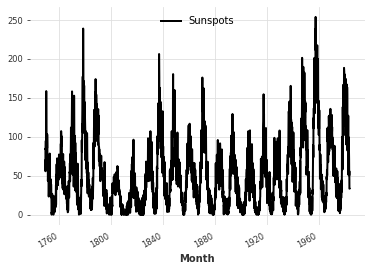

In [11]:
series_sunspot = SunspotsDataset().load()

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

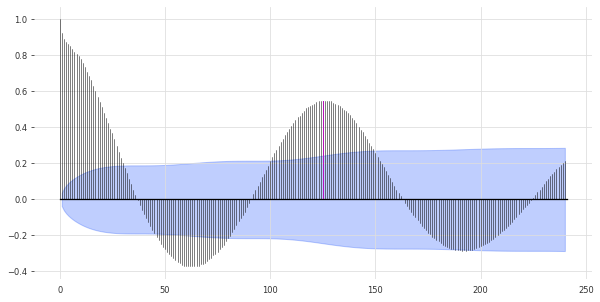

In [12]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [13]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = Scaler()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [14]:
my_model_sun = BlockRNNModel(
    model='GRU',
    input_chunk_length=125,
    output_chunk_length=36,
    hidden_size=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    model_name='sun_GRU',
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True
)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

In [15]:
# Compute the backtest predictions with the two models
pred_series = my_model_sun.historical_forecasts(series_sp_transformed,
                                                start=pd.Timestamp('19401001'), 
                                                forecast_horizon=36,
                                                stride=10,
                                                retrain=False,
                                                last_points_only=True,
                                                verbose=True)

pred_series_ets = ExponentialSmoothing(seasonal_periods=120).historical_forecasts(series_sp_transformed,
                                                                                  start=pd.Timestamp('19401001'), 
                                                                                  forecast_horizon=36,
                                                                                  stride=10,
                                                                                  retrain=True,
                                                                                  last_points_only=True,
                                                                                  verbose=True)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

RNN MAPE: 71.86777453068686
ETS MAPE: 116.63591326597222


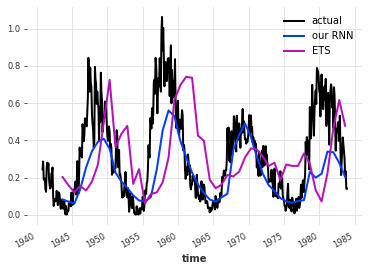

In [16]:
val_sp_transformed.plot(label='actual')
pred_series.plot(label='our RNN')
pred_series_ets.plot(label='ETS')
plt.legend();
print("RNN MAPE:", mape(pred_series, val_sp_transformed))
print("ETS MAPE:", mape(pred_series_ets, val_sp_transformed))